In [52]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [53]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [54]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2024-03-10 16:01:09--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.1s    

2024-03-10 16:01:09 (770 KB/s) - ‘names-long.csv’ saved [85538/85538]



In [55]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [56]:
!tail names-long.csv

6476,zeshan
6477,zhini
6478,ziarul
6479,zile
6480,zina
6481,zishan
6482,ziyabul
6483,zoya
6484,zuhaib
6485,zuveb


In [57]:
words = pd.read_csv("names-long.csv")["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

words = words.sample(frac = 1).reset_index(drop = True)
words = words.tolist()

words = [word for word in words if word.isalpha()]
words[:10]

['saranjeet',
 'sadip',
 'mohatter',
 'lalutha',
 'pratibha',
 'firdous',
 'sandeep',
 'sahnaz',
 'gur',
 'farjana']

In [58]:
len(words)

6184

In [59]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}


In [ ]:
block_size = 6 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [61]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 6]), torch.int64, torch.Size([44325]), torch.int64)

In [62]:
# Embedding layer for the context
emb_dim = 2
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [63]:
emb.weight

Parameter containing:
tensor([[ 0.5220,  0.0162],
        [ 0.1894,  0.0781],
        [ 0.3721,  0.3052],
        [ 0.2254,  0.6668],
        [-2.2955, -0.0151],
        [-0.0755, -0.2642],
        [ 0.9417, -0.9265],
        [-0.9625,  1.1753],
        [ 0.4864, -0.5371],
        [-0.6372, -0.4283],
        [ 0.0284,  0.5672],
        [-1.3793, -0.7582],
        [ 0.4994, -0.3768],
        [-0.2832, -0.9823],
        [-1.6238, -0.4614],
        [-2.8765, -0.3749],
        [ 0.9643, -1.6277],
        [ 0.9879, -0.0256],
        [ 1.0436, -0.3276],
        [-0.4915,  0.1236],
        [-1.1678, -0.9190],
        [-1.0855, -0.9678],
        [ 1.2815, -0.6230],
        [ 0.2802, -0.4228],
        [ 0.5220,  1.1404],
        [-0.1180,  0.2964],
        [-1.7289,  1.0965]], requires_grad=True)

In [64]:
emb.weight.shape

torch.Size([27, 2])

<Axes: >

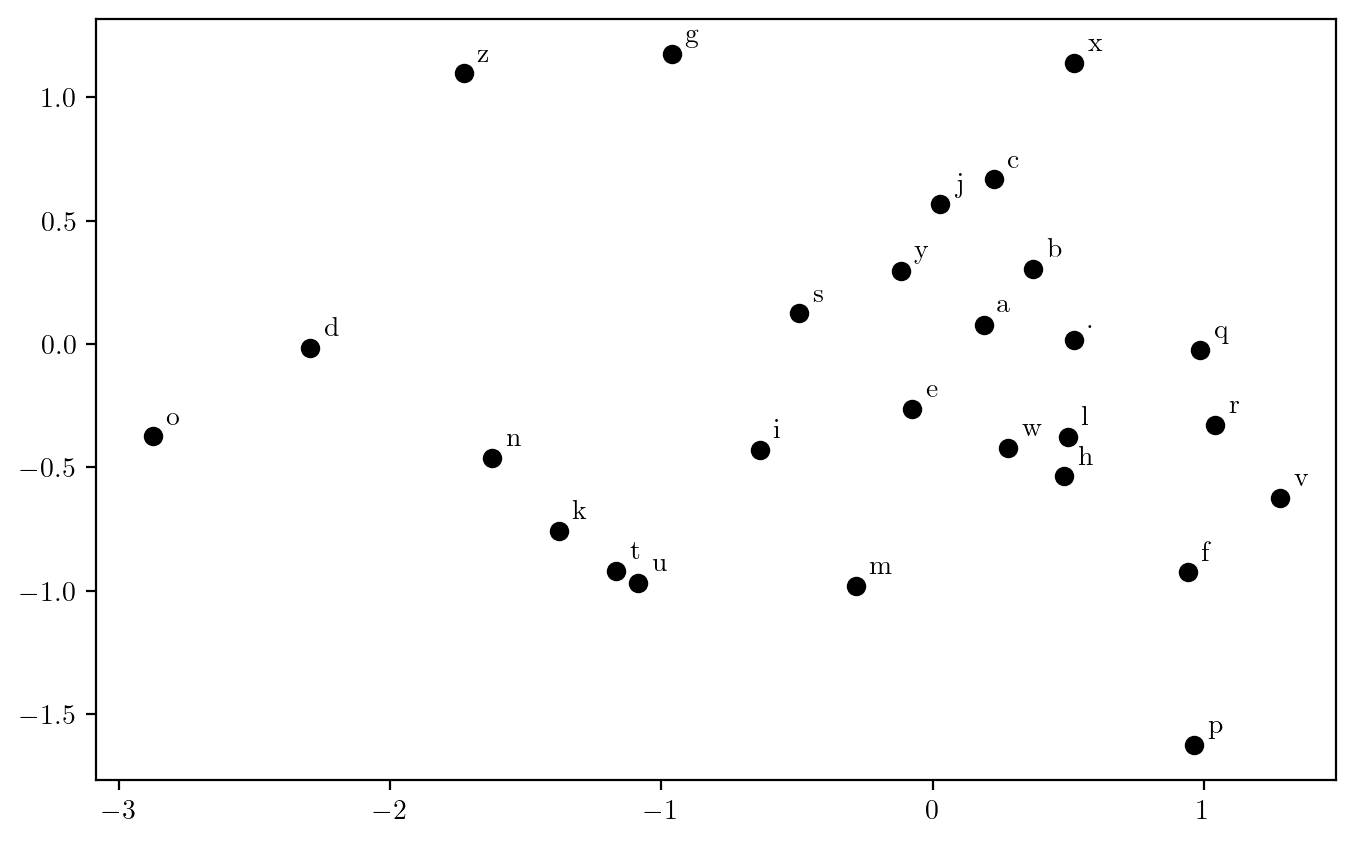

In [65]:
# # Function to visualize the embedding in 2d space
latexify(columns = 2, fig_width = 8)
def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./Embed.svg)
![Alt](./ModelEmbed.svg)

In [66]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x

## Generating names from untrained model

In [70]:
model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(42)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

rpbfjbovpb
w
rm
dzjy
rlmwvygoic
ypeyfigw
zhq
jlqcnxbciv
xwbwjfgqgi
ablvwyycra


In [71]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([27, 2])
_orig_mod.lin1.weight torch.Size([10, 12])
_orig_mod.lin1.bias torch.Size([10])
_orig_mod.lin2.weight torch.Size([27, 10])
_orig_mod.lin2.bias torch.Size([27])


## Model Training

In [72]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 2.926828384399414
100 2.1831865310668945
200 2.175992727279663
300 2.171600580215454
400 2.1683430671691895


KeyboardInterrupt: 

## Visualize the Learnt Embedding

<Axes: >

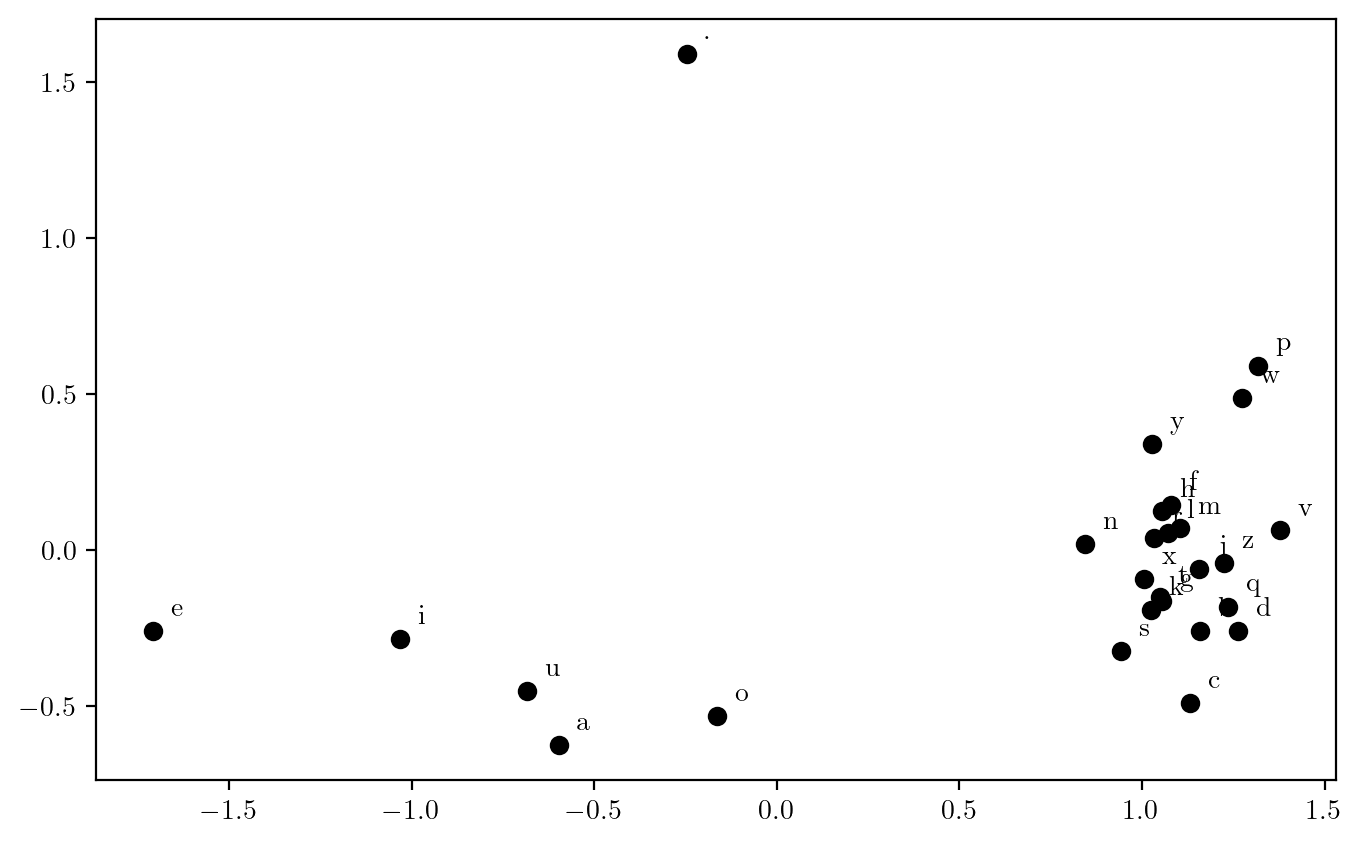

In [73]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Names from the Model

In [74]:
for i in range(20):
    print(generate_name(model, itos, stoi, block_size))

rakhajr
retun
zahsu
jamuj
rafana
nichet
raytit
sab
nulti
ridipa
bhahya
abhoim
santeekh
pahsn
bilidazul
plovim
pafavria
pital
meeradn
shakhveend
